In [1]:
import pandas as pd
import missingno as msno
import seaborn as sns
import datetime as dt
from datetime import datetime
df_migration_pre = pd.read_csv("dataset_migration.csv")
df_hdi_pre = pd.read_csv("HDI_Index.csv")

In [101]:
def dateto_ordinal(df,date_column):
    #Función para convertir fecha a tipo ordinal
    df['Fecha_Numerico']=df[date_column].map(dt.datetime.toordinal)
    return df

def country_code_num(df):
    #Funcion para crear diccionario codigo pais y "label_encoder"
    country_code = df["Country Code"].unique()
    country_code = country_code.tolist()
    country_code_c = {}
    keys = country_code
    values = range(1, len(keys)+1)
    for key, value in zip(keys, values):
        country_code_c[key] = value
    #Add new column Country_code_num
    df["country_code_c"] = df["Country Code"].map(country_code_c)
    #Funcion para crear diccionario id pais y "label_encoder"
    num_country_code = {v: k for k, v in country_code_c.items()}
    return df

def clearna (df):
    #Funcion para eliminar registros nulos
    df.dropna(inplace=True)
    return df

def dropcolumns_for_ml(df):
    #Funcion para dejar columnas de tipo float para el modelo de ml
    df = df.drop(["Country Code","Year","Unemployment Advanced Education (%)","Unemployment Intermediate Education (%)", "Unemployment Basic Education (%)","Labor Taxes and Contributions (%)","Social Protection and Labor Programs (%)","Poverty Rate (%)"],axis=1)
    return df

def dropcolumns(df):
    #Funcion para eliminar columnas
    df = df.drop(["Unemployment Advanced Education (%)","Unemployment Intermediate Education (%)", "Unemployment Basic Education (%)","Labor Taxes and Contributions (%)","Social Protection and Labor Programs (%)","Poverty Rate (%)"],axis=1)
    return df

def preprodata(df_migration,df_hdi):
    #Funcion para preprocesamiento de datos
    #unir dataframes
    df = df_migration.merge(df_hdi, how="left", on=["Country Name", "Country Code", "Year"])
    #eliminar columnas redundanes o que no tienen importancia en el modelo
    df.drop(["Unnamed: 0_x","Unnamed: 0_y"], axis= 1, inplace=True)
    df.drop("PIB Growth (%)", axis= 1, inplace=True)
    #Convertir year as date
    df["Year"] = pd.to_datetime(df["Year"].astype(str),format= "%Y")
    df= dateto_ordinal(df,"Year")
    df = country_code_num(df)
    df_ml = df
    df = dropcolumns(df)
    df = clearna(df)
    df_ml = dropcolumns_for_ml(df_ml)
    df_ml = clearna(df_ml)
    return df_ml , df

#Función para reducir datos ssegun lista de paises determinado
def country_reduce(df,list_country):
    mask = df["Country Name"].isin(list_country)
    df_filtered = df[mask]
    return df_filtered

#Función para convertir año en formato (str) a número ordinal
def convert_year_to_ordinal(year_input):
    year_num = datetime.strptime(year_input,'%Y').toordinal()
    return year_num

#Funcion para elegir datos por un año
def year_filter(df,year_str):
    year_num = convert_year_to_ordinal(year_str)
    mask = df["Fecha_Numerico"] == year_num 
    df_filtered = df[mask]
    return df_filtered

#Funcion para elegir datos por un intervalo de años
def year_filter_range(df,year_str_min,year_str_max):
    year_num_min = convert_year_to_ordinal(year_str_min)
    year_num_max = convert_year_to_ordinal(year_str_max)
    mask = (df.Fecha_Numerico>=year_num_min)&(df.Fecha_Numerico<= year_num_max)
    df_filtered = df[mask]
    return df_filtered

In [3]:
#Lista de paises para el modelo ML paises receptores y emisores en conjunto
country_list =['Afganistán','Francia','China','Canadá','India','España',
                'México','Alemania','Venezuela','Italia','Pakistán','Estados Unidos',
               'Ucrania','Arabia Saudita','Bangladesh','Australia','República Árabe Siria',	
               'Reino Unido','Yemen, Rep. del','Federación de Rusia']

#Ejecución función de preprocesamiento
dfm_total_ml, dfm_total = preprodata(df_migration_pre,df_hdi_pre)
dfm_ml = country_reduce(dfm_total_ml,country_list)
dfm_total = country_reduce(dfm_total,country_list)

In [4]:
print(dfm_ml["Country Name"].value_counts())
print(dfm_ml.info())
print(dfm_total.info())

Australia                21
Italia                   21
Estados Unidos           21
Ucrania                  21
República Árabe Siria    21
Arabia Saudita           21
Federación de Rusia      21
Pakistán                 21
Bangladesh               21
México                   21
India                    21
Reino Unido              21
Francia                  21
España                   21
Alemania                 21
China                    21
Canadá                   21
Yemen, Rep. del          19
Afganistán               19
Venezuela                15
Name: Country Name, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 10 to 4543
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country Name             410 non-null    object 
 1   Net Migration            410 non-null    float64
 2   PIB per Capita           410 non-null    float64
 3   Total Unemployment (%)   4

In [5]:
print(dfm_ml.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 10 to 4543
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country Name             410 non-null    object 
 1   Net Migration            410 non-null    float64
 2   PIB per Capita           410 non-null    float64
 3   Total Unemployment (%)   410 non-null    float64
 4   human_development_index  410 non-null    float64
 5   Fecha_Numerico           410 non-null    int64  
 6   country_code_c           410 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 25.6+ KB
None


In [6]:
#Función para ejecutar modelo no supervisado

def func_scaler(df):
    X_in = df.drop(["Fecha_Numerico","Country Name"],axis=1).values
    #Escalar X
    #Escalado de todos los features Min_Max scaler
    # Import MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler
    # Instantiate MinMaxScaler
    MM_scaler = MinMaxScaler()
    # Fit MM_scaler to the data
    MM_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = MM_scaler.transform(X_in)
    return X

def func_scaler_standard(df):
    X_in = df.drop(["Fecha_Numerico","Country Name"],axis=1).values
    #Escalar X
    #Escalado de todos los features Min_Max scaler
    # Import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    # Instantiate MinMaxScaler
    STD_scaler = StandardScaler()
    # Fit MM_scaler to the data
    STD_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = STD_scaler.transform(X_in)
    return X

def func_clusters(X_in,number_of_clusters):
    from sklearn.cluster import KMeans
    kmeans=KMeans(n_clusters=number_of_clusters,random_state=0)
    kmeans.fit(X_in)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    return labels, centroids

X = func_scaler(dfm_ml)
labels, centroids = func_clusters(X,4)

c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
#Add labels to Dataframes
def add_labels(df,labels_in):
    df["labels"] =labels_in
    return df

#Function to show clusters
def func_groupby(df):
    df_group = df.groupby("labels").value_counts().reset_index(name='count')
    print(df.groupby("labels")["Country Name"].value_counts())
    df_group =df_group.drop("count",axis=1)
    return df_group

dfm_ml = add_labels(dfm_ml,labels)
df_group = func_groupby(dfm_ml)
df_group.labels.value_counts()

C:\Users\julia\AppData\Local\Temp\ipykernel_6364\1450896543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"] =labels_in


labels  Country Name         
0       Arabia Saudita           21
        Federación de Rusia      21
        México                   21
        Pakistán                 21
        República Árabe Siria    21
        Ucrania                  21
        Yemen, Rep. del          19
        Venezuela                15
1       Bangladesh               21
        India                    21
        Afganistán               19
        China                    13
2       Alemania                 21
        Australia                21
        Canadá                   21
        España                   21
        Francia                  21
        Italia                   21
        Reino Unido              21
        China                     8
3       Estados Unidos           21
Name: Country Name, dtype: int64


0    160
2    155
1     74
3     21
Name: labels, dtype: int64

In [19]:
#Generación de cluster - 2
X = func_scaler(dfm_ml)
labels_2, centroids_2 = func_clusters(X,2)
dfm_ml = add_labels(dfm_ml,labels_2)
df_group_2 = func_groupby(dfm_ml)
df_group_2.labels.value_counts()
df_group_2.to_csv("df_group_2.csv",index=False)

#Generate Cross tabulation - para ver como se distribuye cada pais 
#ct = pd.crosstab(df_group_2['labels'],df_group_2['Country Name'])
#print(ct)

labels  Country Name         
0       Arabia Saudita           21
        Federación de Rusia      21
        México                   21
        Pakistán                 21
        República Árabe Siria    21
        Ucrania                  21
        Yemen, Rep. del          19
        Venezuela                15
        India                    10
1       Alemania                 21
        Australia                21
        Bangladesh               21
        Canadá                   21
        China                    21
        España                   21
        Estados Unidos           21
        Francia                  21
        Italia                   21
        Reino Unido              21
        Afganistán               19
        India                    11
Name: Country Name, dtype: int64


c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\julia\AppData\Local\Temp\ipykernel_6364\1450896543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"] =labels_in


In [10]:
#Generación de cluster - 4
X = func_scaler(dfm_ml)
labels_4, centroids_4 = func_clusters(X,4)
dfm_ml = add_labels(dfm_ml,labels_4)
df_group_4 = func_groupby(dfm_ml)
df_group_4.labels.value_counts()
df_group_4.to_csv("df_group_4.csv",index=False)

c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\julia\AppData\Local\Temp\ipykernel_6364\1450896543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"] =labels_in


labels  Country Name         
0       Arabia Saudita           21
        Federación de Rusia      21
        México                   21
        Pakistán                 21
        República Árabe Siria    21
        Ucrania                  21
        Yemen, Rep. del          19
        Venezuela                15
        India                    10
1       Bangladesh               21
        Afganistán               19
        China                    13
        India                    11
2       Alemania                 21
        Australia                21
        Canadá                   21
        España                   21
        Francia                  21
        Italia                   21
        Reino Unido              21
        China                     8
3       Estados Unidos           21
Name: Country Name, dtype: int64


In [11]:
#Generación cluster solo para año 2020
#Generando Data Frame filtrado por el último año
dfm_ml_year = year_filter(dfm_ml,"2020")

#Generación de cluster - 3
X_year = func_scaler(dfm_ml_year)
labels_4_2020, centroids_4_2020 = func_clusters(X_year,4)
dfm_ml_year = add_labels(dfm_ml_year,labels_4_2020)
df_group_4_2020 = func_groupby(dfm_ml_year)
df_group_4_2020.labels.value_counts()
df_group_4_2020.to_csv("df_group_4_2020.csv",index=False)

labels  Country Name         
0       Arabia Saudita           1
        Federación de Rusia      1
        México                   1
        Pakistán                 1
        República Árabe Siria    1
        Ucrania                  1
1       Alemania                 1
        Australia                1
        Canadá                   1
        China                    1
        España                   1
        Francia                  1
        Italia                   1
        Reino Unido              1
2       Estados Unidos           1
3       Afganistán               1
        Bangladesh               1
        India                    1
Name: Country Name, dtype: int64


c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\julia\AppData\Local\Temp\ipykernel_6364\1450896543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"] =labels_in


In [12]:
#Generación cluster solo para año 2020
#Generando Data Frame filtrado por el último año
dfm_ml_year = year_filter(dfm_ml,"2020")

#Generación de cluster - 6
X_year = func_scaler(dfm_ml_year)
labels_6_2020, centroids_6_2020 = func_clusters(X_year,6)
dfm_ml_year = add_labels(dfm_ml_year,labels_6_2020)
df_group_6_2020 = func_groupby(dfm_ml_year)
df_group_6_2020.labels.value_counts()
df_group_6_2020.to_csv("df_group_6_2020.csv",index=False)

labels  Country Name         
0       Arabia Saudita           1
        México                   1
        Pakistán                 1
1       Alemania                 1
        Australia                1
        Canadá                   1
        China                    1
        Francia                  1
        Italia                   1
        Reino Unido              1
2       Estados Unidos           1
3       Afganistán               1
        Bangladesh               1
        India                    1
4       Federación de Rusia      1
        República Árabe Siria    1
        Ucrania                  1
5       España                   1
Name: Country Name, dtype: int64


c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\julia\AppData\Local\Temp\ipykernel_6364\1450896543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"] =labels_in


c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

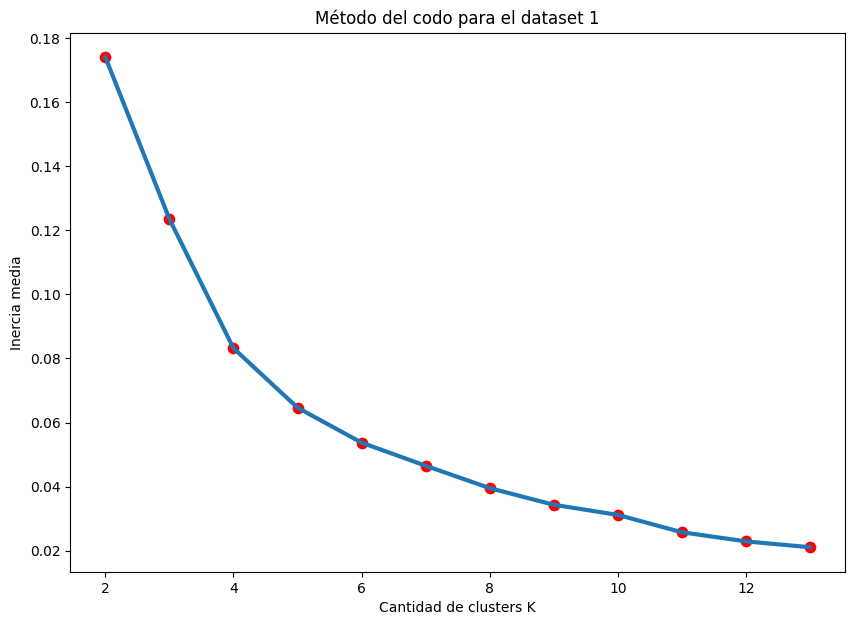

In [21]:
#K-Means Elbow method
#Se basa en medir la inercia (indicativo de dispersión de los datos-distancia de cada muestra al centroide del cluster al que pertenece) menos inercia mejor
#Un buen agrupamiento tiene agrupaciones estrechas (baja inercia) pero tampoco tiene muchos clusters (overfitting)
#Se elige el codo en el diagrama de inercia donde la inercia comienza a disminuir lentamente 
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Creamos una lista donde iremos guardando las distancias medias
Sum_of_squared_distances = []

X = func_scaler(dfm_ml)
#labels_4, centroids_4 = func_clusters(X,4)

# Entrenamos un modelo para cada número de cluster que queremos testear
K = np.arange(2,14)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    
    # Calculamos la distancia media y agregamos a la lista
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,X.shape[0])
    Sum_of_squared_distances.append(distancia_media)

plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el dataset 1')

plt.show()

c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

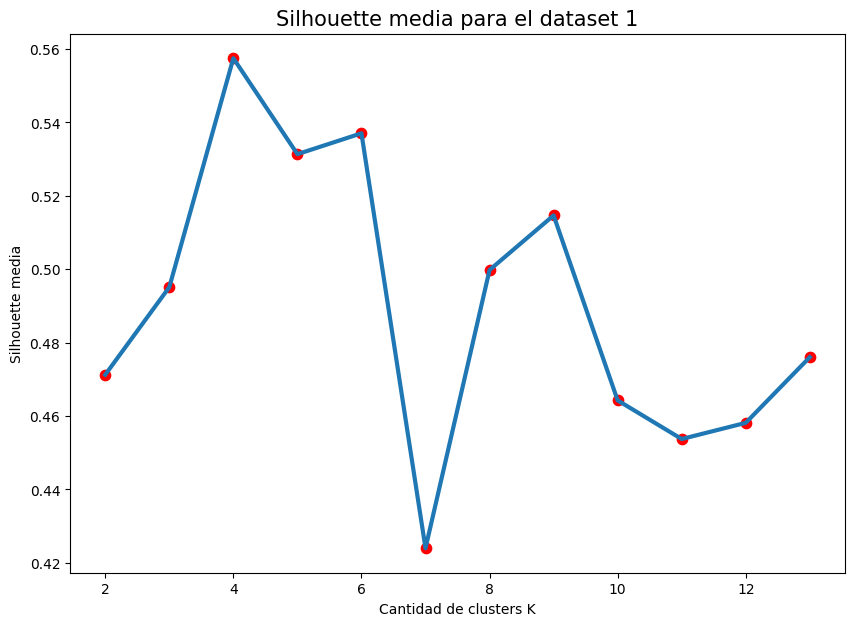

In [14]:
from sklearn.metrics import silhouette_samples, silhouette_score
#Método Silhouette
# Creamos una lista donde iremos guardando los valores medios de silhouette
lista_sil = []
# Ingresamos el Dataset con el que queremos trabajar
X = func_scaler(dfm_ml)

# Entrenamos un modelo para cada número de cluster que queremos testear
for k in range(2,14):
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    
    # Tomamos las etiquetas
    etiquetas = km.labels_
    
    # Calculamos el silhouette 
    valor_medio_sil = silhouette_score(X, etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para el dataset 1', fontsize = 15)

plt.show()

c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

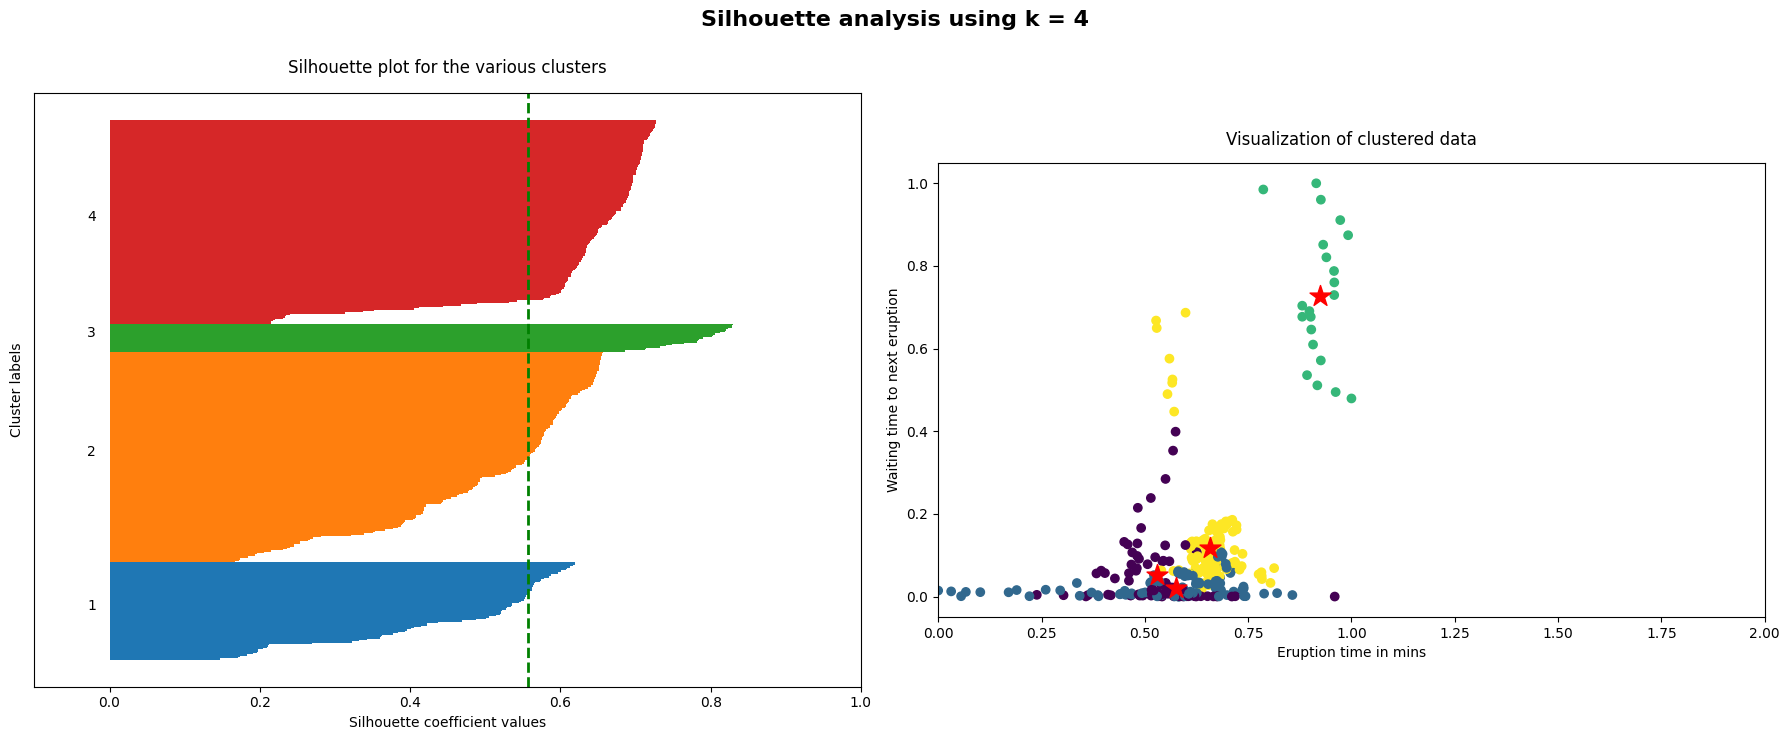

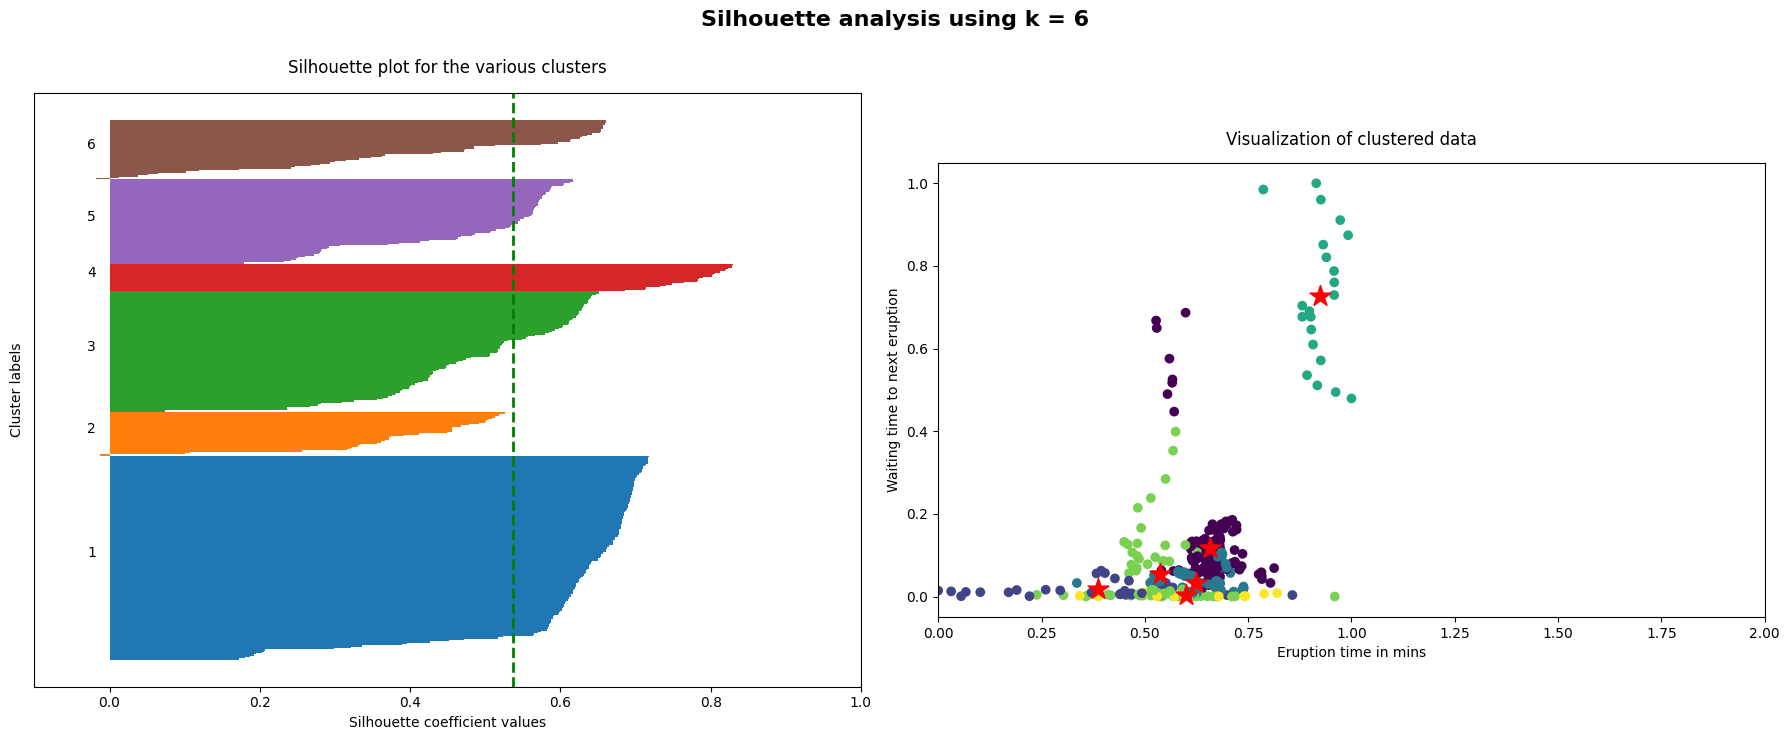

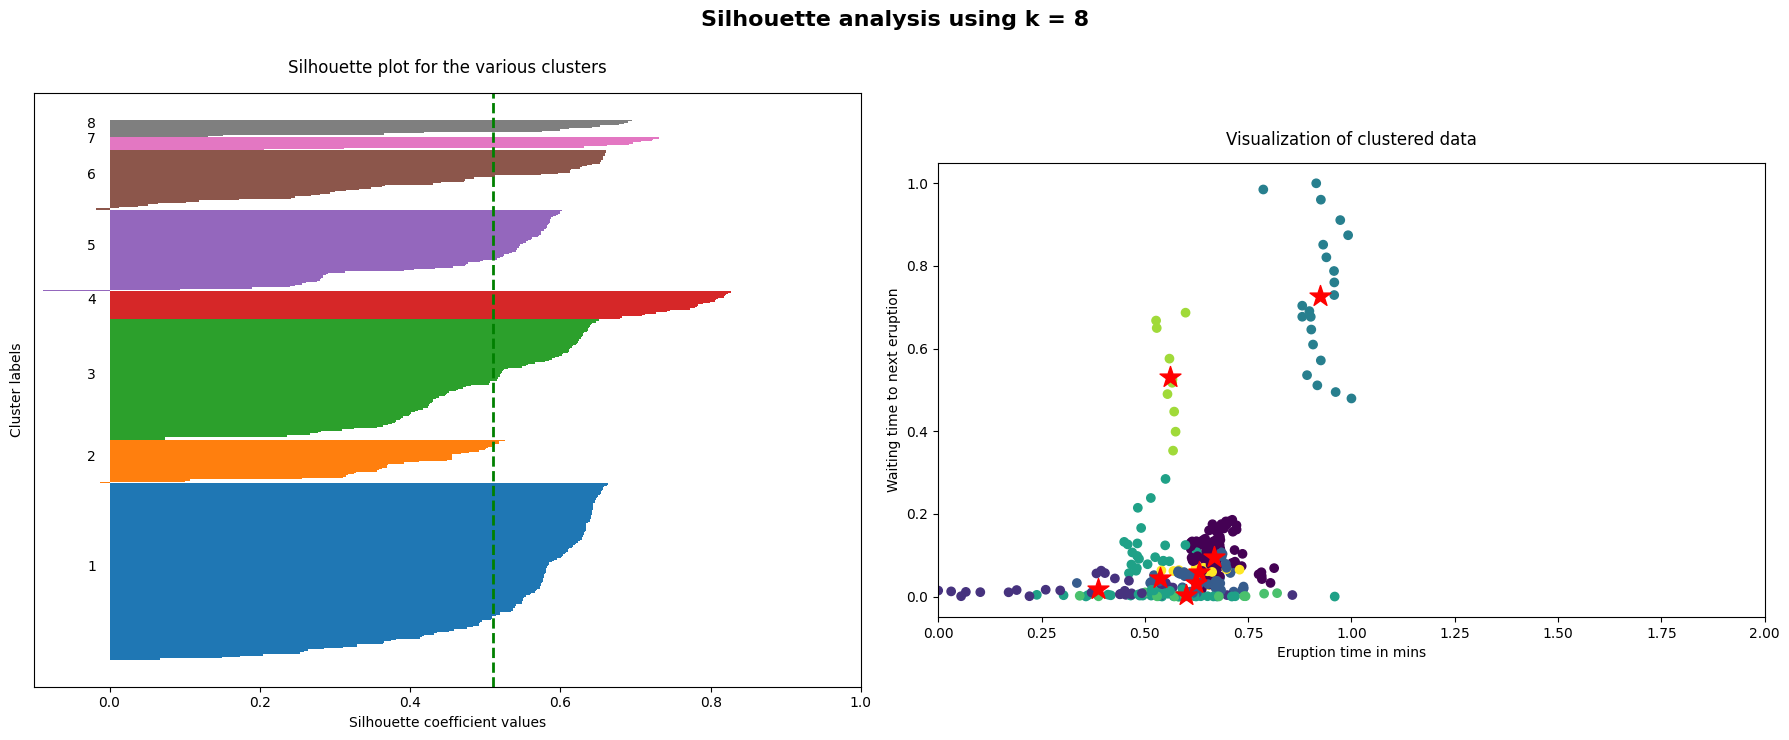

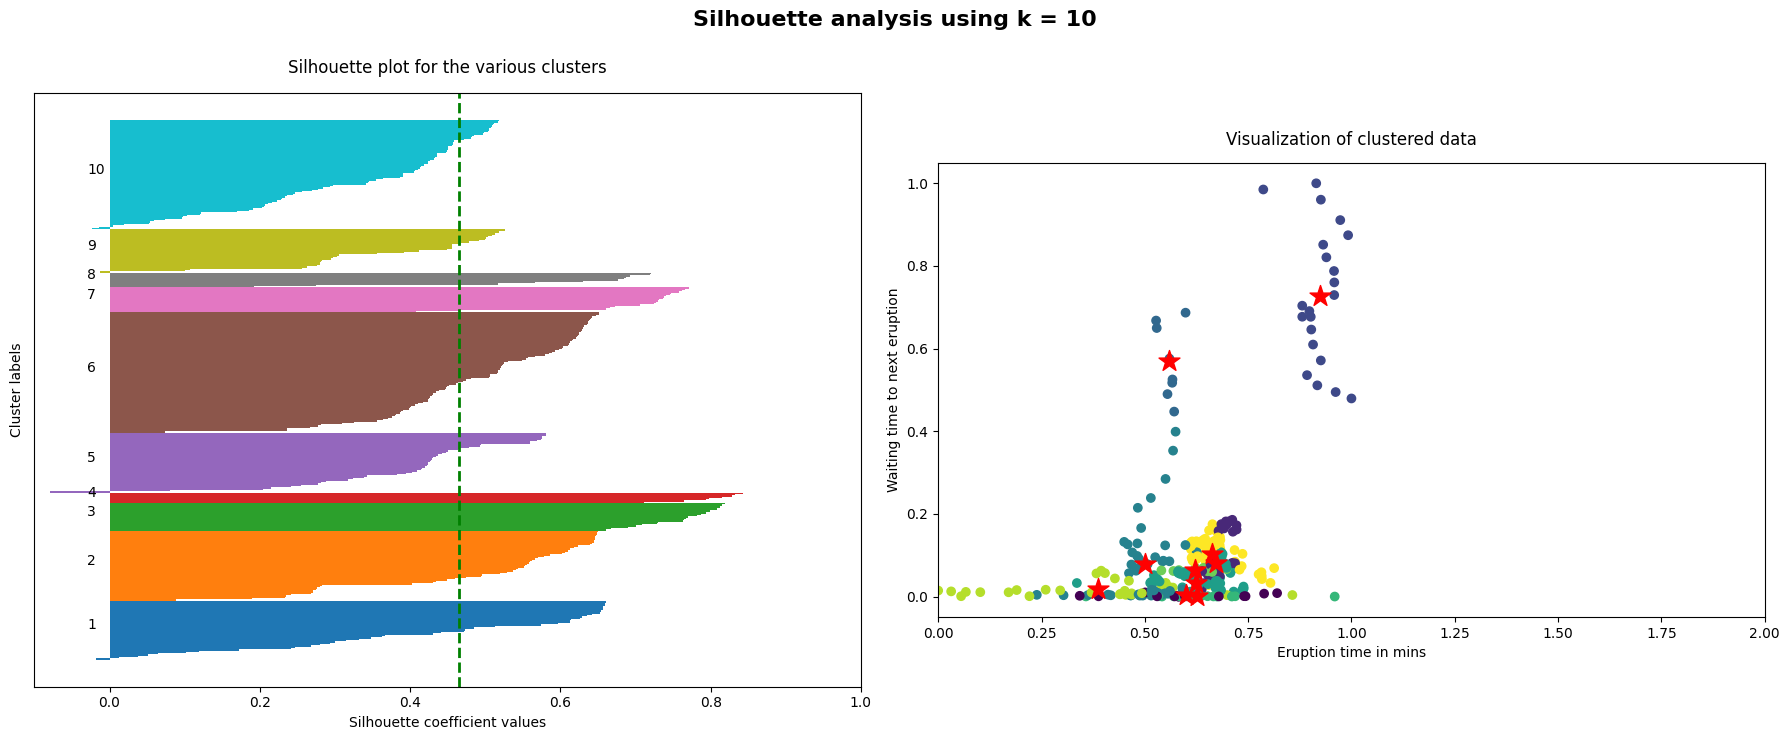

In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Ingresamos el Dataset con el que queremos trabajar
X_std = func_scaler(dfm_ml)

# Definimos la lista de los K que queremos graficae
lista_k = [4, 6, 8, 10]

for i, k in enumerate(lista_k):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Instanciamos el modelo
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    silhouette_vals = silhouette_samples(X_std, labels)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([0, 2])
    ax2.set_xlim([0, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

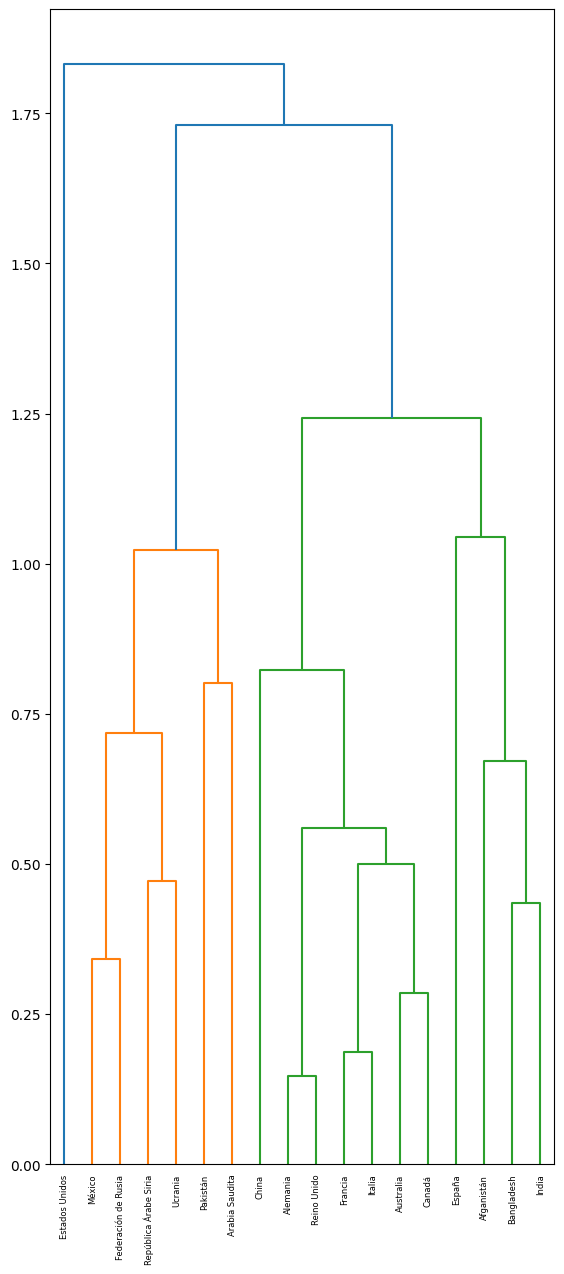

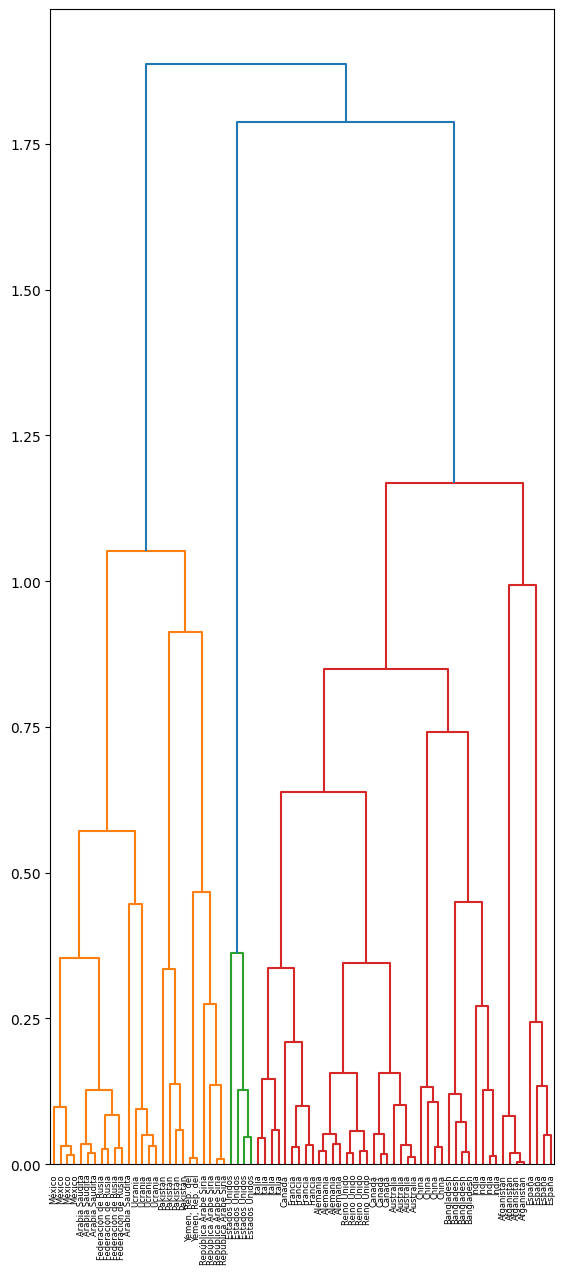

In [114]:
#Hierarchical clustering - Dendogram (Para ver el clustering jerarquico) para el ultimo ño
#Generando Data Frame filtrado por el último año
def hiercluster(X_in,df):
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import linkage, dendrogram
    samples = X_in
    mergings = linkage(samples, method='complete')
    country_name = df['Country Name'].to_list()
    dendrogram(mergings,
    labels = country_name,
    leaf_rotation=90,
    leaf_font_size=6)
    # plotting a line plot after changing it's width and height
    plt.rcParams["figure.figsize"] = [6.5, 15]
    plt.show()

dfm_ml_year = year_filter(dfm_ml,"2020")
X_year = func_scaler(dfm_ml_year)
X = func_scaler(dfm_ml)

dfm_ml_year_range  = year_filter_range(dfm_ml,"2017","2020")
X_year_range = func_scaler(dfm_ml_year_range)
hiercluster(X_year,dfm_ml_year)
hiercluster(X_year_range,dfm_ml_year_range)


In [ ]:
print(dfm_ml_year_range.head(-10))

In [ ]:
dfm_ml.head()

c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


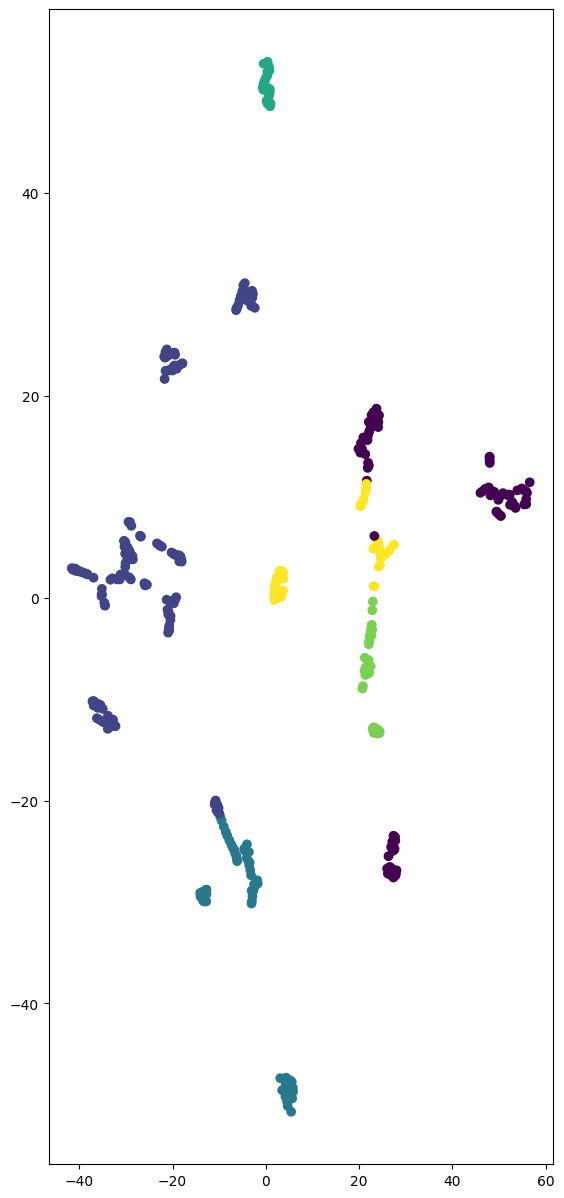

In [126]:
#tsne-visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
dfm_ml_year = year_filter(dfm_ml,"2020")
dfm_ml = dfm_ml

def tsne_visual(df,number_clusters,perplexiti_in,):
    X = func_scaler(df)
    #En labels podria ser usar el encoding del nombre de paises
    labels, centroids = func_clusters(X,number_clusters)
    model = TSNE(learning_rate=100,perplexity = perplexiti_in)
    transformed = model.fit_transform(X)
    xs = transformed[:,0]
    ys = transformed[:,1]
    plt.scatter(xs, ys, c=labels)
    plt.show()

tsne_visual(dfm_ml,6,15)